In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths


In [2]:
# path to the dataset, saved model and the plot of the training loss and accuracy
datasetPath = r'D:\ComputerVision\dataset'
savedModelPath = r'D:\ComputerVision\resnet_facemask.model'
savedPlotPath = r'D:\ComputerVision\plot_facemask_resnet.png'


## Data Preprocessing

In [3]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
imagePaths = list(paths.list_images(datasetPath))

data = []
labels = []

# loop over the image paths
for i in imagePaths:
    # extract the class label from the filename
    label = i.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    # Pre-processing steps include resizing to 224×224 pixels
    image = load_img(i, target_size=(224, 224))
    # conversion to array format
    image = img_to_array(image)
    # and scaling the pixel intensities in the input image to the range [-1, 1] (via the preprocess_input convenience function)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    labels.append(label)
    data.append(image)


In [4]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype='float32')
labels = np.array(labels)


In [5]:
data.shape


(1376, 224, 224, 3)

In [6]:
np.unique(labels)


array(['with_mask', 'without_mask'], dtype='<U12')

In [7]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [8]:
# each element of our labels array consists of an array in which only one index is “hot”
labels


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [9]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
train_X, test_X, train_Y, test_Y = train_test_split(
    data, labels, test_size=0.20, stratify=labels, random_state=42)


In [10]:
train_X.shape


(1100, 224, 224, 3)

In [11]:
train_Y.shape


(1100, 2)

In [12]:
test_X.shape


(276, 224, 224, 3)

In [13]:
test_Y.shape


(276, 2)

## Data Training

In [14]:
# During training, we’ll be applying on-the-fly mutations to our images in an effort to improve generalization.
# This is known as data augmentation, where the random rotation, zoom, shear, shift, and flip parameters are established.
# We’ll use the aug object at training time.

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')


In [15]:
# Prepare ResNet50 for fine-tuning

# Step 1: Load ResNet50 with pre-trained ImageNet weights, leaving off head of network

# load the ResNet50 network, ensuring the head FC layer sets are
# left off
baseModel = ResNet50(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

baseModel.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [16]:
# Step 2: Construct a new FC head, and append it to the base in place of the old head

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [17]:
# Step 3: Freeze the base layers of the network.
# The weights of these base layers will not be updated during the process of backpropagation, whereas the head layer weights will be tuned.

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [18]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32


In [19]:
# Compile our model with the Adam optimizer, a learning rate decay schedule, and binary cross-entropy.

# compile our model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [20]:
# Face mask training is launched. Our data augmentation object (aug) will be providing batches of mutated image data.

# train the head of the network
H = model.fit(
    aug.flow(train_X, train_Y, batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(test_X, test_Y),
    validation_steps=len(test_X)//BS,
    epochs=EPOCHS
)


Epoch 1/20
34/34 [==============================] - 127s 4s/step - loss: 0.7861 - accuracy: 0.5159 - val_loss: 0.6592 - val_accuracy: 0.6993
Epoch 2/20
34/34 [==============================] - 127s 4s/step - loss: 0.6989 - accuracy: 0.5827 - val_loss: 0.6204 - val_accuracy: 0.6884
Epoch 3/20
34/34 [==============================] - 205s 6s/step - loss: 0.6632 - accuracy: 0.6049 - val_loss: 0.6031 - val_accuracy: 0.7101
Epoch 4/20
34/34 [==============================] - 229s 7s/step - loss: 0.6530 - accuracy: 0.6161 - val_loss: 0.5950 - val_accuracy: 0.7029
Epoch 5/20
34/34 [==============================] - 211s 6s/step - loss: 0.6393 - accuracy: 0.6573 - val_loss: 0.5916 - val_accuracy: 0.7101
Epoch 6/20
34/34 [==============================] - 184s 5s/step - loss: 0.6316 - accuracy: 0.6536 - val_loss: 0.5729 - val_accuracy: 0.7101
Epoch 7/20
34/34 [==============================] - 208s 6s/step - loss: 0.6193 - accuracy: 0.6779 - val_loss: 0.5648 - val_accuracy: 0.7283
Epoch 8/20
34

In [21]:
# serialize the model to disk
model.save(savedModelPath, save_format="h5")

C:\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Model Evaluating

In [22]:
# Evaluate the resulting model on the test set

# make predictions on the testing set
predIdxs = model.predict(test_X, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(test_Y.argmax(
    axis=1), predIdxs, target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.81      0.78      0.80       138
without_mask       0.79      0.82      0.80       138

    accuracy                           0.80       276
   macro avg       0.80      0.80      0.80       276
weighted avg       0.80      0.80      0.80       276



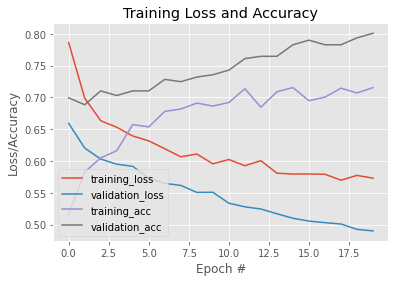

In [23]:
# plot the training loss and accuracy

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="training_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="validation_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="training_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="validation_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(savedPlotPath)
